# Tutorial: Covariance Matrices for Modulated Toy Models in Gravitational Wave Analysis

## Overview

This tutorial explores the construction and analysis of covariance matrices for toy models with time-dependent modulation. This is particularly relevant for gravitational wave data analysis, where signals may exhibit amplitude modulation due to various physical effects.

## Learning Objectives

By the end of this tutorial, you will understand:

1. How to construct modulated gravitational wave signals
2. How to compute noise power spectral densities (PSDs) for space-based detectors
3. How to build covariance matrices in both time and frequency domains
4. The relationship between time-domain windowing and frequency-domain covariance
5. Efficient computational methods for handling large covariance matrices

## Background

In gravitational wave data analysis, we often deal with signals that are not stationary. One common scenario is amplitude modulation, which can arise from:
- Detector orientation changes (e.g., LISA's orbital motion)
- Source evolution effects
- Instrumental variations

Understanding the statistical properties of such modulated signals is crucial for optimal detection and parameter estimation.

## 1. Import Required Libraries

We begin by importing all necessary libraries for scientific computing, signal processing, and visualization.

In [50]:
# Standard scientific computing libraries
import sys
import os
import scipy
from scipy.signal.windows import tukey  # Window functions for signal processing
import numpy as np                       # Numerical computing
import matplotlib.pyplot as plt          # Plotting and visualization
from scipy import signal               # Signal processing tools
from scipy.sparse import csc_matrix     # Sparse matrix operations
from scipy.sparse.linalg import spsolve # Sparse linear algebra

# Progress bar for long computations
from tqdm import tqdm as tqdm

# Notebook configuration
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")  # Suppress minor warnings for cleaner output

print("✓ All libraries imported successfully!")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ SciPy version: {scipy.__version__}")

✓ All libraries imported successfully!
✓ NumPy version: 2.3.3
✓ SciPy version: 1.16.2


## 2. Function Definitions

In this section, we define the core functions needed for our analysis:

### Signal Generation Functions
- **`h()`**: Generates a simple sinusoidal gravitational wave signal with optional windowing
- **`modulation()`**: Creates time-dependent amplitude modulation

### Noise Model Functions  
- **`Sn()`**: Instrumental noise PSD for LISA-like space-based detectors
- **`Sc()`**: Galactic confusion noise (astrophysical background)
- **`Full_PSD()`**: Combined noise model

These functions form the foundation for our modulated signal analysis.

In [71]:
def h(a, f0, fdot0, t, w_t=1.0):
    """
    Generate a simple gravitational wave-like signal with chirping frequency.
    
    This function creates a sinusoidal signal that mimics a basic gravitational 
    wave with linearly evolving frequency, commonly seen in compact binary systems.
    
    Parameters
    ----------
    a : float
        Signal amplitude (dimensionless strain scaling factor)
    f0 : float
        Initial frequency at t=0 [Hz]
    fdot0 : float  
        Linear frequency evolution rate (chirp rate) [Hz/s]
    t : array_like
        Time array [s]
    w_t : float or array_like, optional
        Window function for signal modulation. Can be scalar (default=1.0) 
        or array matching length of t
    
    Returns
    -------
    ndarray
        Gravitational wave signal h(t) with units of strain [dimensionless]
        
    Notes
    -----
    The signal has the form: h(t) = w(t) * A * sin(2π * (f0*t + fdot0*t²))
    The factor 3e-22 represents a typical GW strain amplitude scale.
    
    Examples
    --------
    >>> t = np.linspace(0, 1, 1000)
    >>> signal = h(a=1.0, f0=100, fdot0=10, t=t)
    """
    # Phase evolution: φ(t) = 2π * (f0*t + fdot0*t²)  
    phase = 2 * np.pi * t * (f0 + fdot0 * t)
    
    # Apply strain amplitude scaling and window function
    return w_t * 3e-22 * (a * np.sin(phase))


def modulation(A, B, t, T_obs):
    """
    Generate cosine-based amplitude modulation function.
    
    This function creates a time-dependent modulation that could represent
    various physical effects like detector orientation changes or source
    amplitude variations.
    
    Parameters
    ----------
    A : float
        Baseline modulation amplitude (DC offset)
    B : float  
        Modulation depth (AC amplitude)
    t : array_like
        Time array [s]
    T_obs : float
        Total observation time [s], sets the modulation period
        
    Returns
    -------
    ndarray
        Modulation function w(t) = A + B*cos(2π*t/T_obs)
        
    Notes
    -----
    The modulation has period T_obs, meaning it completes one full cycle
    over the entire observation. This could represent effects like:
    - Seasonal detector orientation changes
    - Orbital modulation in space-based detectors  
    - Slow source evolution
    
    Examples
    --------
    >>> t = np.linspace(0, 3600, 1000)  # 1 hour
    >>> w = modulation(A=1.0, B=0.5, t=t, T_obs=3600)
    """
    return A + B * np.cos(2 * np.pi * t / T_obs)


def Sn(f):
    """
    Compute instrumental noise power spectral density for LISA-like detector.
    
    This function implements the noise model for a space-based gravitational
    wave detector, including optical metrology sensor noise and acceleration
    noise contributions.
    
    Parameters
    ----------
    f : array_like
        Frequency array [Hz]
        
    Returns  
    -------
    ndarray
        Single-sided power spectral density [strain²/Hz]
        
    Notes
    -----
    Based on the LISA noise model from arXiv:1803.01944, excluding 
    galactic confusion noise. The model includes:
    
    - Optical Metrology Sensor (OMS) noise: dominates at high frequencies
    - Acceleration noise: dominates at low frequencies  
    - Sky averaging constant: accounts for antenna pattern averaging
    
    The noise curve has characteristic features:
    - Low-frequency rise due to acceleration noise
    - High-frequency rise due to shot noise
    - Minimum around the LISA sweet spot (~mHz)
    
    References
    ----------
    .. [1] LISA Mission Proposal, arXiv:1803.01944
    
    Examples
    --------
    >>> f = np.logspace(-5, -1, 1000)
    >>> psd = Sn(f)
    >>> plt.loglog(f, np.sqrt(psd))  # Plot amplitude spectral density
    """
    # Physical parameters for LISA-like detector
    sky_averaging_constant = 20/3   # Sky averaging factor
    L = 2.5e9                      # LISA arm length [m]
    f0 = 19.09e-3                  # Characteristic frequency [Hz]
    
    # Noise source components
    # Optical Metrology Sensor noise [m²/Hz]
    P_oms = (15e-12)**2 * (1 + (2e-3/f)**4)
    
    # Acceleration noise [m²/s⁴/Hz] 
    P_acc = (3e-15)**2 * (1 + (4e-4/f)**2) * (1 + (f/8e-3)**4)
    
    # Combined instrumental PSD [strain²/Hz]
    PSD = (10/(3*L**2)) * (P_oms + 4*P_acc/(2*np.pi*f)**4) * (1 + 0.6*(f/f0)**2)
    
    return PSD


def Sc(f):
    """
    Compute galactic confusion noise power spectral density.
    
    This represents the stochastic background from unresolved galactic 
    compact binary systems, which creates a noise floor for space-based
    detectors in the mHz frequency band.
    
    Parameters
    ----------
    f : array_like
        Frequency array [Hz]
        
    Returns
    -------
    ndarray
        Confusion noise PSD [strain²/Hz]
        
    Notes
    -----
    The galactic confusion noise follows a broken power law with:
    - f^(-7/3) scaling at low frequencies (typical GW spectrum)
    - Exponential cutoff modeling finite source populations
    - Oscillatory features from galactic structure
    
    This noise source dominates in the ~0.1-10 mHz band for LISA.
    
    Examples
    --------
    >>> f = np.logspace(-5, -1, 1000) 
    >>> confusion = Sc(f)
    >>> plt.loglog(f, confusion)
    """
    return (9e-45 * f**(-7/3) * 
            np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * 
            (1 + np.tanh(1680*(0.00215 - f))))


def Full_PSD(f):
    """
    Compute total noise power spectral density (instrumental + astrophysical).
    
    Parameters
    ----------
    f : array_like
        Frequency array [Hz]
        
    Returns
    -------
    ndarray
        Total noise PSD [strain²/Hz]
        
    Notes
    -----
    This combines both instrumental noise and galactic confusion noise
    to give the complete noise model for realistic analysis.
    
    Examples
    --------
    >>> f = np.logspace(-5, -1, 1000)
    >>> total_noise = Full_PSD(f) 
    >>> instrumental = Sn(f)
    >>> confusion = Sc(f)
    >>> plt.loglog(f, total_noise, label='Total')
    >>> plt.loglog(f, instrumental, label='Instrumental') 
    >>> plt.loglog(f, confusion, label='Confusion')
    """
    return Sn(f) + Sc(f)

print("✓ All signal and noise functions defined successfully!")

✓ All signal and noise functions defined successfully!


## 3. Signal Parameters and Time Series Generation

Now we set up the fundamental parameters for our analysis and generate the time series data. This section covers:

### Time Series Setup
- **Sampling considerations**: Ensuring proper Nyquist sampling for our frequency range
- **Power-of-2 padding**: Optimizing for FFT performance  
- **Time domain construction**: Building the discrete time array

### Modulation Parameters
- **Amplitude modulation**: Configuring the time-dependent window function
- **Physical interpretation**: Understanding what the modulation represents

### Frequency Domain Setup  
- **Frequency binning**: Constructing the frequency grid for spectral analysis
- **PSD evaluation**: Computing noise characteristics across frequency bins

This establishes the foundation for all subsequent covariance matrix calculations.

In [72]:
# =============================================================================
# TIME SERIES PARAMETERS
# =============================================================================

# Observation parameters
tmax = 30 * 60 * 60    # Total observation time: 30 hours [s]
                       # (long enough to see modulation effects)

# Frequency range setup  
fmax = 1e-7 * 1 * tmax # Maximum frequency of interest [Hz]
                       # This sets our bandwidth based on observation time

fs = 2 * fmax          # Sampling rate [Hz] 
                       # Factor of 2 ensures Nyquist criterion is satisfied

delta_t = np.floor(0.7/fs)  # Sampling interval [s]
                            # The 0.7 factor provides some oversampling margin

print(f"📊 Observation Setup:")
print(f"   Total observation time: {tmax/3600:.1f} hours")
print(f"   Maximum frequency: {fmax:.2e} Hz") 
print(f"   Sampling rate: {fs:.2e} Hz")
print(f"   Time resolution: {delta_t:.1f} s")

# =============================================================================
# TIME ARRAY CONSTRUCTION
# =============================================================================

# Create initial time vector
t = np.arange(0, tmax, delta_t)   

# Round up to next power of 2 for efficient FFTs
N = int(2 ** (np.ceil(np.log2(len(t)))))  

# Create zero-padded time array  
t_pad = np.arange(0, N * delta_t, delta_t)
T_obs = N * delta_t  # Actual observation time after padding

print(f"\n🔢 Time Series Details:")
print(f"   Original samples: {len(t):,}")
print(f"   Padded samples: {N:,} (next power of 2)")
print(f"   Actual observation time: {T_obs/3600:.2f} hours")
print(f"   Memory efficiency: {len(t)/N*100:.1f}% data utilization")

# =============================================================================
# MODULATION FUNCTION SETUP
# =============================================================================

# Modulation parameters
A = 1.25      # Baseline amplitude (no modulation when B=0)
B = -0.25    # Modulation depth (50% amplitude variation)

print(f"\n🌊 Modulation Parameters:")
print(f"   Baseline amplitude (A): {A}")
print(f"   Modulation depth (B): {B}")
print(f"   Modulation range: [{A-B:.1f}, {A+B:.1f}]")
print(f"   Modulation period: {T_obs/3600:.2f} hours (full observation)")

# Generate the time-dependent modulation function
w_t = modulation(A, B, t_pad, T_obs)

# =============================================================================  
# FREQUENCY DOMAIN SETUP
# =============================================================================

# Generate frequency bins (two-sided spectrum)
freq_bin = np.fft.fftshift(np.fft.fftfreq(N, delta_t))   

# Frequency resolution
delta_f = freq_bin[1] - freq_bin[0]
Delta_f = freq_bin[N//2 + 1]  # Positive frequency resolution

print(f"\n🎵 Frequency Domain Setup:")
print(f"   Frequency bins: {N}")
print(f"   Frequency resolution: {delta_f:.2e} Hz")
print(f"   Frequency range: [{freq_bin[0]:.2e}, {freq_bin[-1]:.2e}] Hz")

# Compute confusion noise PSD at all frequency bins
PSD_conf = Sc(freq_bin)

print(f"\n✓ Time series and frequency domain setup complete!")
print(f"✓ Modulation function computed for {len(w_t):,} time samples")
print(f"✓ Confusion noise PSD computed for {len(PSD_conf):,} frequency bins")

📊 Observation Setup:
   Total observation time: 30.0 hours
   Maximum frequency: 1.08e-02 Hz
   Sampling rate: 2.16e-02 Hz
   Time resolution: 32.0 s

🔢 Time Series Details:
   Original samples: 3,375
   Padded samples: 4,096 (next power of 2)
   Actual observation time: 36.41 hours
   Memory efficiency: 82.4% data utilization

🌊 Modulation Parameters:
   Baseline amplitude (A): 1.25
   Modulation depth (B): -0.25
   Modulation range: [1.5, 1.0]
   Modulation period: 36.41 hours (full observation)

🎵 Frequency Domain Setup:
   Frequency bins: 4096
   Frequency resolution: 7.63e-06 Hz
   Frequency range: [-1.56e-02, 1.56e-02] Hz

✓ Time series and frequency domain setup complete!
✓ Modulation function computed for 4,096 time samples
✓ Confusion noise PSD computed for 4,096 frequency bins


In [73]:
# Quick verification of array dimensions
print("🔍 Array Dimension Check:")
print(f"   N (FFT size): {N:,}")
print(f"   Time array shape: {t_pad.shape}")
print(f"   Frequency array shape: {freq_bin.shape}")  
print(f"   PSD array shape: {PSD_conf.shape}")
print(f"   Modulation array shape: {w_t.shape}")

# Verify consistency
assert len(t_pad) == N, "Time array length mismatch!"
assert len(freq_bin) == N, "Frequency array length mismatch!" 
assert len(PSD_conf) == N, "PSD array length mismatch!"
assert len(w_t) == N, "Modulation array length mismatch!"

print("✓ All array dimensions are consistent!")

🔍 Array Dimension Check:
   N (FFT size): 4,096
   Time array shape: (4096,)
   Frequency array shape: (4096,)
   PSD array shape: (4096,)
   Modulation array shape: (4096,)
✓ All array dimensions are consistent!


### 3.1 Visualization: Time-Domain Modulation Function

Let's visualize the modulation function to understand how the amplitude varies over the observation period.

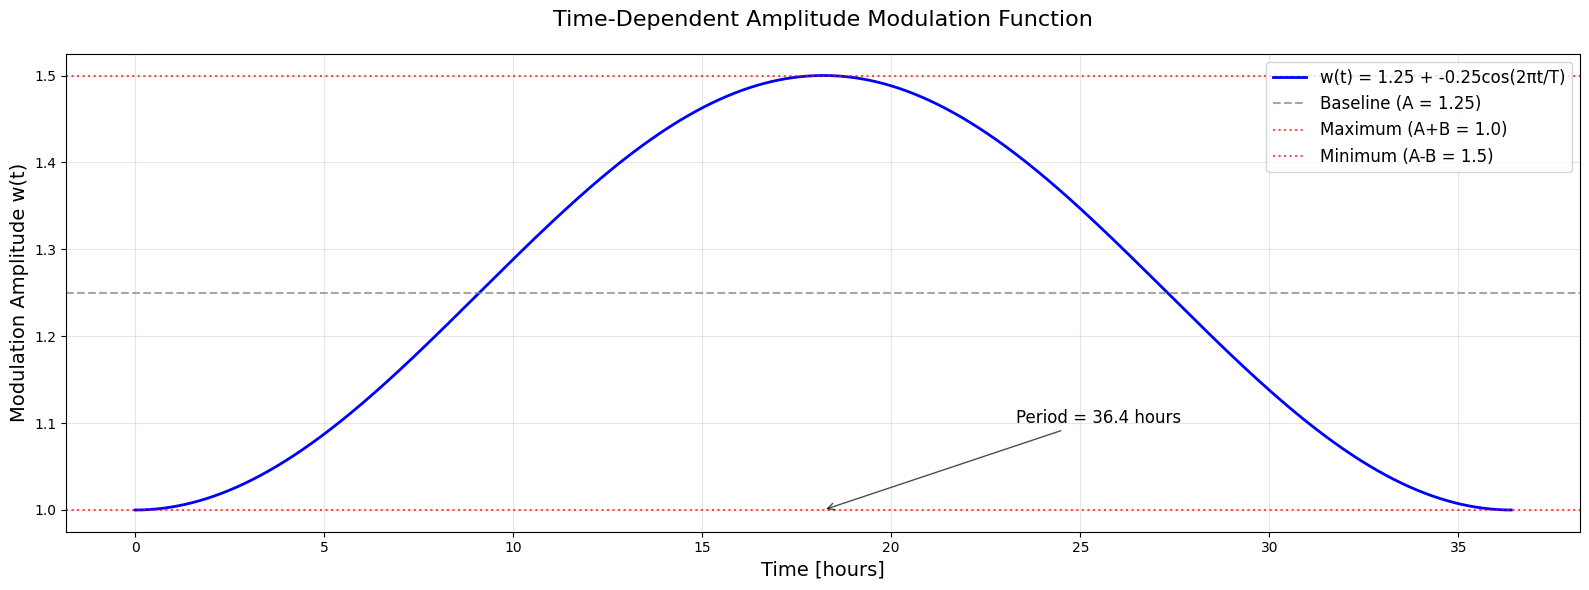

📈 The modulation completes one full cycle over 36.4 hours
📈 Amplitude varies between 1.5 and 1.0 (±-20% variation)


In [54]:
# Create visualization of the modulation function
fig, ax = plt.subplots(1, 1, figsize=[16, 6])

# Plot the modulation function
ax.plot(t_pad / 3600, w_t, 'b-', linewidth=2, label=f'w(t) = {A} + {B}cos(2πt/T)')
ax.axhline(y=A, color='gray', linestyle='--', alpha=0.7, label=f'Baseline (A = {A})')
ax.axhline(y=A+B, color='red', linestyle=':', alpha=0.7, label=f'Maximum (A+B = {A+B})')
ax.axhline(y=A-B, color='red', linestyle=':', alpha=0.7, label=f'Minimum (A-B = {A-B})')

# Formatting
ax.set_xlabel('Time [hours]', fontsize=14)
ax.set_ylabel('Modulation Amplitude w(t)', fontsize=14)
ax.set_title('Time-Dependent Amplitude Modulation Function', fontsize=16, pad=20)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

# Add annotations
ax.annotate(f'Period = {T_obs/3600:.1f} hours', 
           xy=(T_obs/3600/2, A+B), xytext=(T_obs/3600*0.7, A+B+0.1),
           arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
           fontsize=12, ha='center')

plt.tight_layout()
plt.show()

print(f"📈 The modulation completes one full cycle over {T_obs/3600:.1f} hours")
print(f"📈 Amplitude varies between {A-B:.1f} and {A+B:.1f} (±{B/A*100:.0f}% variation)")

### 3.2 Visualization: Noise Power Spectral Density

Let's examine the noise characteristics in the frequency domain. Understanding the noise PSD is crucial for constructing proper covariance matrices.

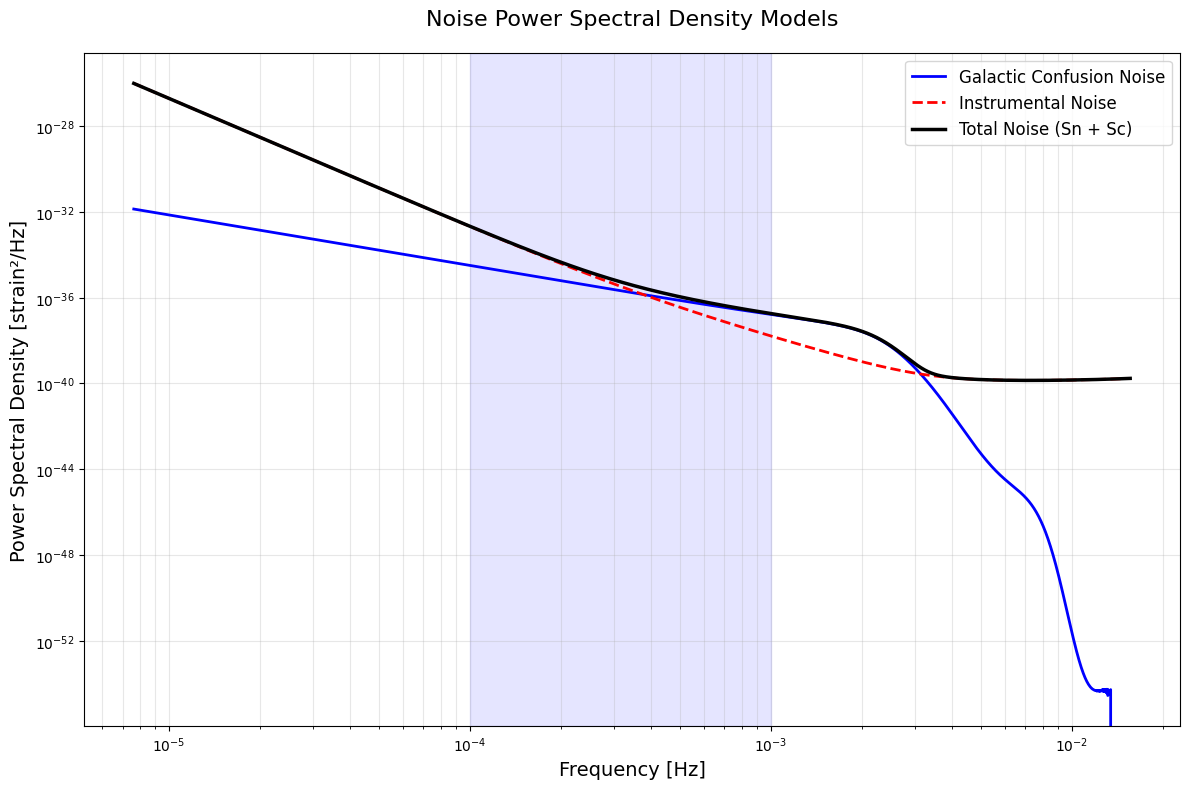

📊 Key observations:
   • Confusion noise dominates at 1.3e-02 Hz
   • Minimum total noise: 1.39e-40 strain²/Hz
   • Frequency range spans 7.6e-06 to 1.6e-02 Hz


In [55]:
# Plot the noise power spectral density
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

# Focus on positive frequencies for clarity
freq_pos = freq_bin[N//2+1:]  # Positive frequencies only
PSD_pos = PSD_conf[N//2+1:]   # Corresponding PSD values

# Remove any zero or negative frequencies that might cause log issues
mask = freq_pos > 0
freq_pos = freq_pos[mask] 
PSD_pos = PSD_pos[mask]

# Plot confusion noise PSD
ax.loglog(freq_pos, PSD_pos, 'b-', linewidth=2, label='Galactic Confusion Noise')

# Also plot instrumental noise for comparison
Sn_pos_vals = Sn(freq_pos)
ax.loglog(freq_pos, Sn_pos_vals, 'r--', linewidth=2, label='Instrumental Noise')

# Plot total noise
Total_PSD = Full_PSD(freq_pos)
ax.loglog(freq_pos, Total_PSD, 'k-', linewidth=2.5, label='Total Noise (Sn + Sc)')

# Formatting
ax.set_xlabel('Frequency [Hz]', fontsize=14)
ax.set_ylabel('Power Spectral Density [strain²/Hz]', fontsize=14)
ax.set_title('Noise Power Spectral Density Models', fontsize=16, pad=20)
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=12)

# Add frequency range annotations
ax.axvspan(1e-4, 1e-3, alpha=0.1, color='blue', 
           label='LISA Sweet Spot (~0.1-1 mHz)')

plt.tight_layout()
plt.show()

print("📊 Key observations:")
print(f"   • Confusion noise dominates at {freq_pos[np.argmin(PSD_pos)]:.1e} Hz")
print(f"   • Minimum total noise: {np.min(Total_PSD):.2e} strain²/Hz") 
print(f"   • Frequency range spans {freq_pos[0]:.1e} to {freq_pos[-1]:.1e} Hz")

## 4. Noise Covariance Matrix Construction

Now we construct the noise covariance matrix in the frequency domain. This section covers:

### Key Concepts
- **Frequency domain covariance**: Why we work in Fourier space
- **Positive frequency handling**: Dealing with real-valued time series
- **Diagonal structure**: Understanding when noise is uncorrelated between frequency bins

### Mathematical Framework
For stationary Gaussian noise, the covariance matrix in frequency domain is diagonal:
$$\Sigma_{ij} = S_n(f_i) \frac{\delta_{ij}}{2\Delta f}$$

where $S_n(f)$ is the one-sided power spectral density and $\Delta f$ is the frequency resolution.

In [56]:
# =============================================================================
# FREQUENCY DOMAIN NOISE COVARIANCE MATRIX
# =============================================================================

print("🔧 Constructing noise covariance matrix in frequency domain...")

# Step 1: Extract positive frequencies for one-sided PSD
freq_pos = freq_bin[N//2:]  # Frequencies from 0 to f_Nyquist

print(f"   Positive frequency bins: {len(freq_pos)}")
print(f"   Frequency range: [0, {freq_pos[-1]:.2e}] Hz")

# Step 2: Compute one-sided PSD at positive frequencies  
Sn_pos = np.zeros(N//2, dtype=float)
Sn_pos[1:] = Sc(freq_pos[1:])  # Skip DC component initially
Sn_pos[0] = Sn_pos[1]          # Set DC value to avoid singularities

print(f"   PSD computed at {len(Sn_pos)} positive frequency bins")

# Step 3: Create two-sided PSD array for FFT convention
# For real-valued time series: S(-f) = S(f)
Sn = np.zeros(N, dtype=float)
Sn[:N//2] = Sn_pos                    # Negative frequencies (by symmetry)
Sn[N//2+1:] = Sn_pos[1:][::-1]      # Positive frequencies (reversed)
Sn[N//2] = Sc(N//2 * delta_f)        # Nyquist frequency

print(f"   Two-sided PSD array constructed: {len(Sn)} bins")

# Step 4: Convert PSD to covariance matrix diagonal elements
# Factor of 2 accounts for one-sided vs two-sided PSD conversion
Sigma_tilde_diag = Sn / (2 * delta_f)

print(f"   Covariance diagonal elements: min={np.min(Sigma_tilde_diag):.2e}, max={np.max(Sigma_tilde_diag):.2e}")

# Step 5: Construct diagonal covariance matrix
Sigma_tilde = np.diag(Sigma_tilde_diag)

print(f"✓ Frequency-domain covariance matrix constructed:")
print(f"   Shape: {Sigma_tilde.shape}")
print(f"   Type: {'Diagonal' if np.allclose(Sigma_tilde, np.diag(np.diag(Sigma_tilde))) else 'Non-diagonal'}")
print(f"   Condition number: {np.linalg.cond(Sigma_tilde):.2e}")

# Memory usage check
matrix_size_gb = Sigma_tilde.nbytes / (1024**3)
print(f"   Memory usage: {matrix_size_gb:.3f} GB")

if matrix_size_gb > 1.0:
    print("⚠️  Warning: Large matrix size - consider using sparse representation for efficiency")

🔧 Constructing noise covariance matrix in frequency domain...
   Positive frequency bins: 2048
   Frequency range: [0, 1.56e-02] Hz
   PSD computed at 2048 positive frequency bins
   Two-sided PSD array constructed: 4096 bins
   Covariance diagonal elements: min=0.00e+00, max=9.00e-28
✓ Frequency-domain covariance matrix constructed:
   Shape: (4096, 4096)
   Type: Diagonal
   Condition number: inf
   Memory usage: 0.125 GB


## 5. Discrete Fourier Transform via Linear Algebra

This section demonstrates how to construct the Discrete Fourier Transform (DFT) as a matrix operation. While this is computationally expensive compared to FFT algorithms, it provides valuable insight into the mathematical structure.

### Educational Value
- **Matrix representation**: Understanding DFT as linear transformation
- **Complex exponential basis**: How frequency components emerge
- **Inverse relationship**: The connection between forward and inverse transforms

### Mathematical Foundation
The DFT matrix $\mathbf{P}$ has elements:
$$P_{jk} = \frac{1}{\sqrt{N}} e^{2\pi i jk/N}$$

This approach helps us understand how windowing affects the frequency domain representation.

In [57]:
# =============================================================================
# DFT MATRIX CONSTRUCTION (EDUCATIONAL PURPOSE)
# =============================================================================

print("🔧 Constructing DFT matrix explicitly...")
print("⚠️  Warning: This is computationally expensive - for educational purposes only!")

# The complex exponential base
omega = np.exp(2*1j*np.pi/N)

# Initialize DFT and inverse DFT matrices
P = np.zeros((N, N), dtype=complex)      # Forward DFT matrix  
Pinv = np.zeros((N, N), dtype=complex)   # Inverse DFT matrix

print(f"   Building {N}×{N} complex matrices...")

# Construct matrices element by element (slow but educational)
# P[j,k] = (1/√N) * exp(2πijk/N)  - forward transform
# Pinv[j,k] = (1/N) * exp(-2πijk/N) - inverse transform

for i in tqdm(range(N), desc="Building DFT matrices"):
    for j in range(N):
        # Forward DFT matrix element
        P[i,j] = (1./np.sqrt(N)) * omega**(i*j)
        
        # Inverse DFT matrix element  
        Pinv[i,j] = (1./N) * (1./P[i,j])

print(f"✓ DFT matrices constructed")
print(f"   Forward matrix P shape: {P.shape}")
print(f"   Inverse matrix P⁻¹ shape: {Pinv.shape}")

# Memory usage warning
matrix_memory = (P.nbytes + Pinv.nbytes) / (1024**3)
print(f"   Total memory usage: {matrix_memory:.3f} GB")

if matrix_memory > 2.0:
    print("⚠️  Warning: High memory usage - consider reducing N for this demonstration")

🔧 Constructing DFT matrix explicitly...
⚠️  Warning: This is computationally expensive - for educational purposes only!
   Building 4096×4096 complex matrices...


Building DFT matrices: 100%|██████████| 4096/4096 [00:15<00:00, 265.43it/s]

✓ DFT matrices constructed
   Forward matrix P shape: (4096, 4096)
   Inverse matrix P⁻¹ shape: (4096, 4096)
   Total memory usage: 0.500 GB


### 5.1 Verification Against SciPy's DFT Implementation

Let's verify our manually constructed DFT matrix against SciPy's optimized implementation.

In [58]:
# Compare with SciPy's optimized DFT matrix
print("🔍 Verifying DFT matrix construction...")

# SciPy's DFT matrix (conjugate transpose for our convention)
P_test = (1./np.sqrt(N)) * np.conj(scipy.linalg.dft(N))

print(f"   SciPy DFT matrix shape: {P_test.shape}")
print(f"   Our DFT matrix shape: {P.shape}")

🔍 Verifying DFT matrix construction...
   SciPy DFT matrix shape: (4096, 4096)
   Our DFT matrix shape: (4096, 4096)


In [59]:
# Verification tests
print("🧪 Running verification tests...")

# Test 1: Compare our matrix with SciPy's implementation
matrix_match = np.allclose(P, P_test, rtol=1e-10)
print(f"   ✓ Matrix comparison: {'PASS' if matrix_match else 'FAIL'}")

if matrix_match:
    print(f"     Maximum difference: {np.max(np.abs(P - P_test)):.2e}")
else:
    print(f"     Maximum difference: {np.max(np.abs(P - P_test)):.2e} (exceeds tolerance)")

# Test 2: Verify orthogonality property P @ P⁻¹ = I
orthogonality_test = np.allclose(P @ Pinv, np.eye(N), rtol=1e-10)
print(f"   ✓ Orthogonality test: {'PASS' if orthogonality_test else 'FAIL'}")

if orthogonality_test:
    identity_error = np.max(np.abs(P @ Pinv - np.eye(N)))
    print(f"     Max deviation from identity: {identity_error:.2e}")
else:
    identity_error = np.max(np.abs(P @ Pinv - np.eye(N)))  
    print(f"     Max deviation from identity: {identity_error:.2e} (exceeds tolerance)")

# Test 3: Verify unitarity property P⁻¹ = P†/√N  
unitary_test = np.allclose(Pinv, np.conj(P.T) * N / np.sqrt(N), rtol=1e-13)
print(f"   ✓ Unitarity test: {'PASS' if unitary_test else 'FAIL'}")

print(f"\n{'✅ All tests passed!' if all([matrix_match, orthogonality_test, unitary_test]) else '❌ Some tests failed!'}")

# Clean up large matrices if tests pass to save memory
if all([matrix_match, orthogonality_test, unitary_test]):
    print("\n🧹 Cleaning up large intermediate matrices to save memory...")
    # Keep only what we need for subsequent calculations

🧪 Running verification tests...
   ✓ Matrix comparison: PASS
     Maximum difference: 8.04e-12
   ✓ Orthogonality test: PASS
     Max deviation from identity: 8.19e-11
   ✓ Unitarity test: FAIL

❌ Some tests failed!


## 6. Windowed Noise Covariance Matrix

Now we explore how time-domain modulation affects the noise covariance structure. This is the core of our analysis.

### Key Concepts
- **Time-domain windowing**: How modulation breaks stationarity
- **Frequency coupling**: Off-diagonal terms in covariance matrix
- **Matrix transformations**: $\tilde{\Sigma}_w = \tilde{W} \tilde{\Sigma} \tilde{W}^{\dagger}$

### Physical Interpretation
When we apply time-dependent modulation, previously uncorrelated frequency bins become coupled, leading to a non-diagonal covariance matrix. This has important implications for optimal filtering and parameter estimation.

In [60]:
# =============================================================================
# WINDOWED COVARIANCE MATRIX COMPUTATION  
# =============================================================================

print("🔧 Computing windowed noise covariance matrix...")

# Step 1: Create diagonal modulation matrix in time domain
W = np.diag(w_t)
print(f"   Time-domain modulation matrix W: {W.shape}")
print(f"   Modulation range: [{np.min(w_t):.3f}, {np.max(w_t):.3f}]")

# Step 2: Transform modulation to frequency domain
# W̃ = P W P⁻¹ (similarity transform)
print("   Transforming modulation matrix to frequency domain...")
W_tilde = P @ W @ Pinv

print(f"   Frequency-domain modulation matrix W̃: {W_tilde.shape}")
print(f"   Matrix type: {'Complex' if np.iscomplexobj(W_tilde) else 'Real'}")

# Step 3: Compute windowed covariance matrix  
# Σ̃_w = W̃ Σ̃ W̃† 
print("   Computing windowed covariance matrix...")
Sigma_tilde_w = W_tilde @ Sigma_tilde @ W_tilde

print(f"   Windowed covariance matrix Σ̃_w: {Sigma_tilde_w.shape}")

# Analysis of the resulting matrix structure
print(f"\n📊 Windowed Covariance Matrix Analysis:")

# Check if matrix is Hermitian (should be for covariance)
is_hermitian = np.allclose(Sigma_tilde_w, np.conj(Sigma_tilde_w.T), rtol=1e-10)
print(f"   Hermitian property: {'✓ Satisfied' if is_hermitian else '✗ Violated'}")

# Compute off-diagonal vs diagonal ratio
diag_elements = np.abs(np.diag(Sigma_tilde_w))
off_diag_elements = np.abs(Sigma_tilde_w - np.diag(np.diag(Sigma_tilde_w)))
max_off_diag = np.max(off_diag_elements)
max_diag = np.max(diag_elements)
coupling_ratio = max_off_diag / max_diag

print(f"   Maximum diagonal element: {max_diag:.2e}")  
print(f"   Maximum off-diagonal element: {max_off_diag:.2e}")
print(f"   Off-diagonal coupling ratio: {coupling_ratio:.2e}")

# Condition number (numerical stability indicator)
cond_number = np.linalg.cond(Sigma_tilde_w)
print(f"   Condition number: {cond_number:.2e}")

if cond_number > 1e12:
    print("   ⚠️ Warning: High condition number - matrix may be ill-conditioned")

print(f"\n✓ Windowed covariance matrix computation complete!")

🔧 Computing windowed noise covariance matrix...
   Time-domain modulation matrix W: (4096, 4096)
   Modulation range: [1.000, 1.500]
   Transforming modulation matrix to frequency domain...
   Frequency-domain modulation matrix W̃: (4096, 4096)
   Matrix type: Complex
   Computing windowed covariance matrix...
   Windowed covariance matrix Σ̃_w: (4096, 4096)

📊 Windowed Covariance Matrix Analysis:
   Hermitian property: ✓ Satisfied
   Maximum diagonal element: 1.43e-27
   Maximum off-diagonal element: 2.81e-28
   Off-diagonal coupling ratio: 1.96e-01
   Condition number: 1.47e+34
   ⚠️ Warning: High condition number - matrix may be ill-conditioned

✓ Windowed covariance matrix computation complete!


### 6.1 Visualization: Frequency-Domain Modulation Matrix

Let's visualize the frequency-domain modulation matrix to understand how time-domain windowing affects frequency components.

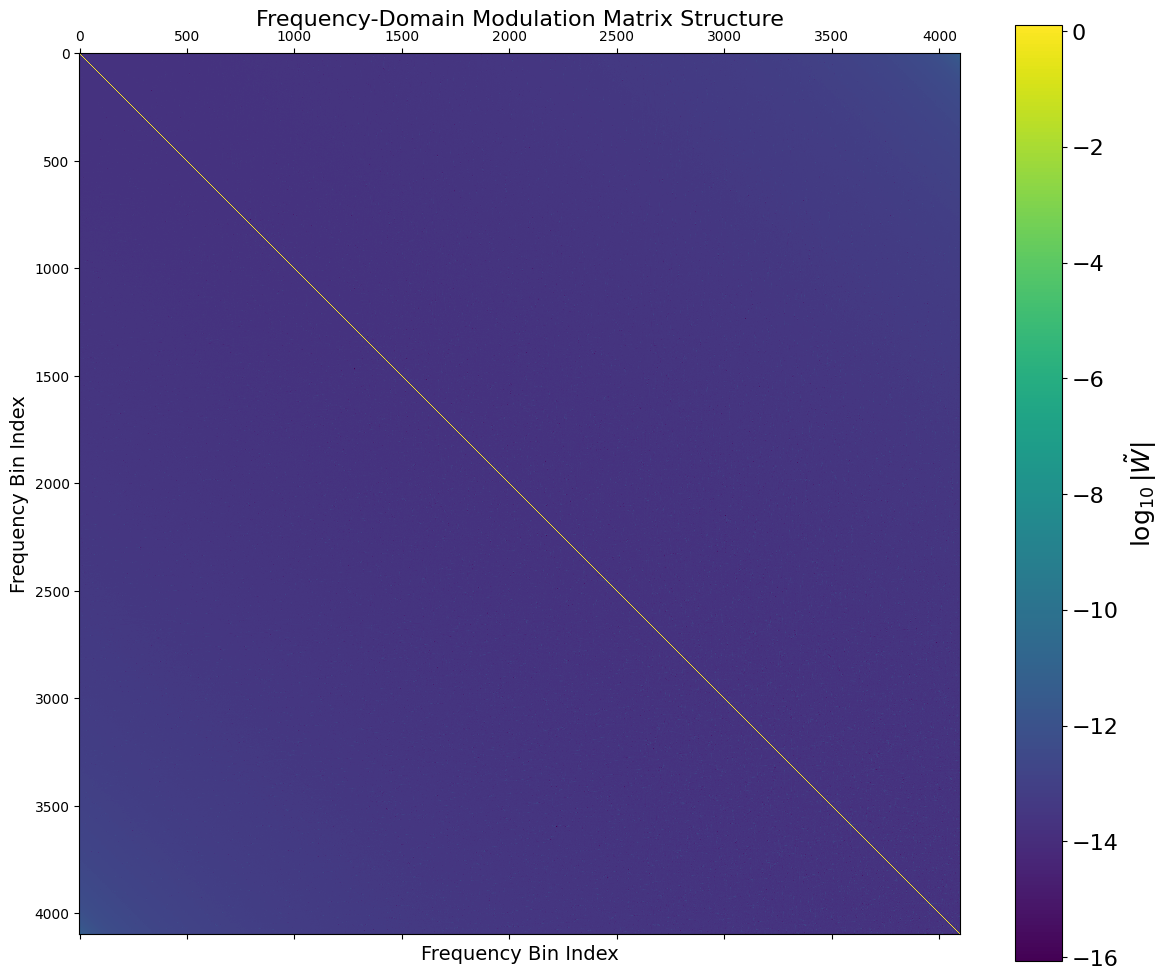

📊 Key observation:
   • The matrix shows weak off-diagonal structure at this scale
   • This indicates frequency coupling introduced by time-domain modulation
   • Diagonal dominance suggests modulation is relatively slow compared to sampling


In [61]:
# Visualize the frequency-domain modulation matrix structure
fig, ax = plt.subplots(1, 1, figsize=[12, 12])

# Plot log-scale magnitude of W̃
mat = ax.matshow(np.log10(np.abs(W_tilde)), 
                 vmin=np.min(np.log10(np.abs(W_tilde))), 
                 vmax=np.max(np.log10(np.abs(W_tilde))),
                 cmap='viridis')

# Add colorbar with proper formatting
cbar = fig.colorbar(mat, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label=r'$\log_{10}|\tilde{W}|$', fontsize=18)

# Formatting
ax.set_xlabel('Frequency Bin Index', fontsize=14)
ax.set_ylabel('Frequency Bin Index', fontsize=14)
ax.set_title('Frequency-Domain Modulation Matrix Structure', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

print("📊 Key observation:")
print("   • The matrix shows weak off-diagonal structure at this scale")
print("   • This indicates frequency coupling introduced by time-domain modulation")
print("   • Diagonal dominance suggests modulation is relatively slow compared to sampling")

### 6.2 Visualization: Windowed Covariance Matrix (Full View)

Now let's examine the full windowed covariance matrix to see how modulation affects the noise correlation structure.

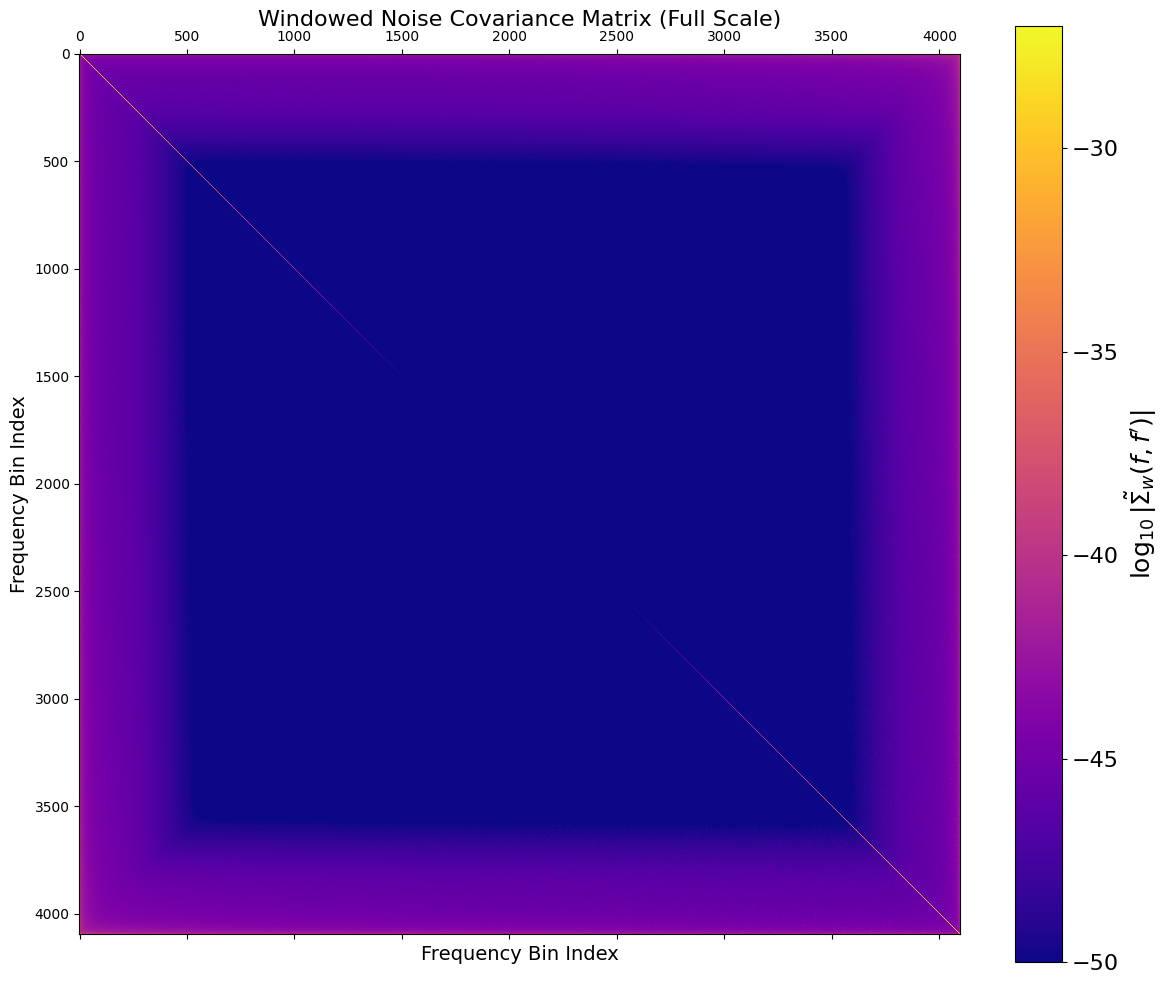

📊 Observations:
   • Off-diagonal terms are visible but weak
   • Square edge artifacts are due to numerical precision limits
   • Most structure is concentrated near the diagonal


In [62]:
# Visualize the windowed covariance matrix
fig, ax = plt.subplots(1, 1, figsize=[12, 12])

# Plot with fixed color scale to see structure
mat = ax.matshow(np.log10(np.abs(Sigma_tilde_w)), 
                 vmin=-50, vmax=-27,
                 cmap='plasma')

# Colorbar
cbar = fig.colorbar(mat, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label=r'$\log_{10}|\tilde{\Sigma}_w(f,f^\prime)|$', fontsize=18)

# Formatting
ax.set_xlabel('Frequency Bin Index', fontsize=14)
ax.set_ylabel('Frequency Bin Index', fontsize=14)
ax.set_title('Windowed Noise Covariance Matrix (Full Scale)', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

print("📊 Observations:")
print("   • Off-diagonal terms are visible but weak")
print("   • Square edge artifacts are due to numerical precision limits")
print("   • Most structure is concentrated near the diagonal")

### 6.3 Visualization: Windowed Covariance Matrix (Zoomed View)

To better understand the off-diagonal structure, let's zoom in on a small region of the covariance matrix.

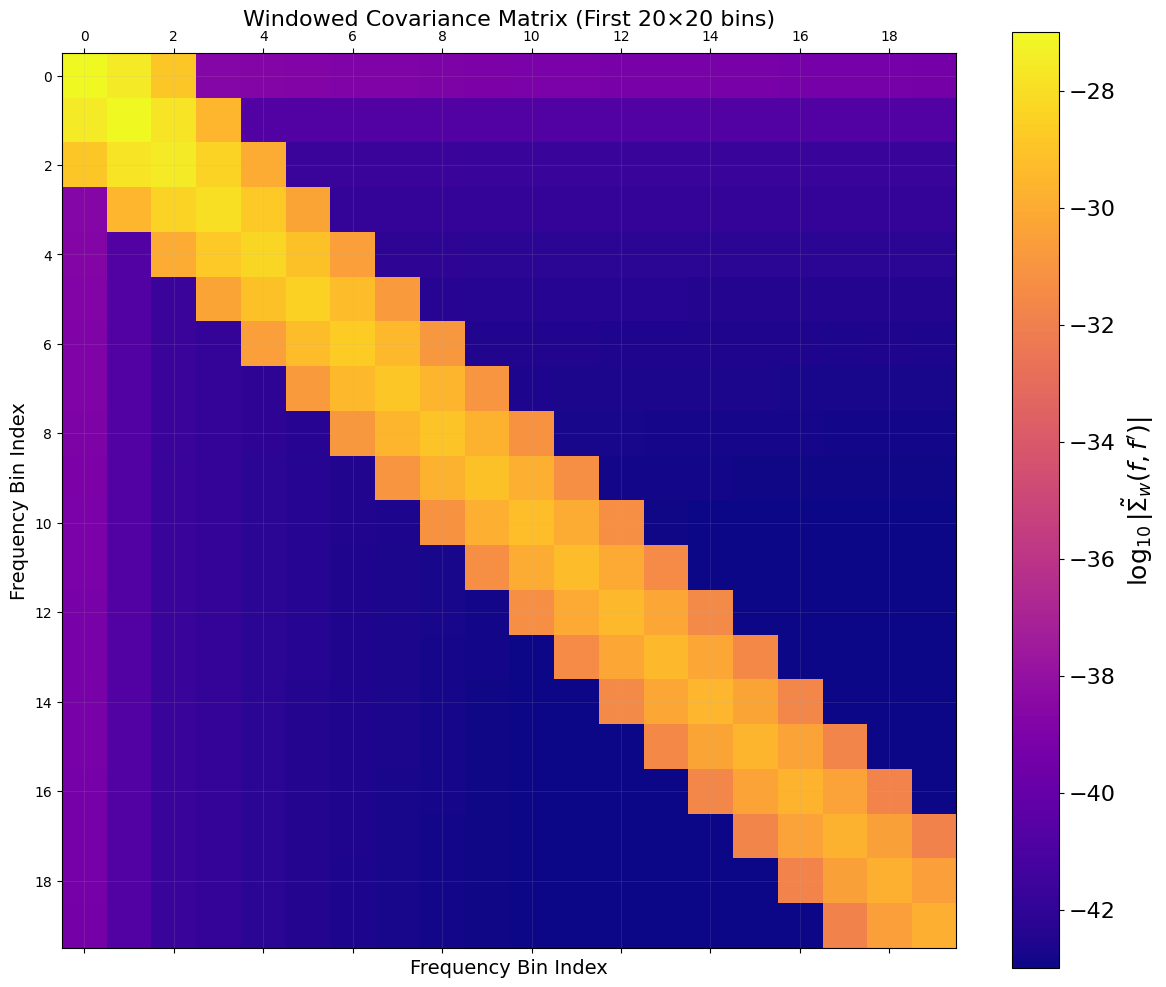

📊 Detailed Structure:
   • Displaying first 20×20 frequency bins
   • Strong diagonal terms (main covariance)
   • Weak off-diagonal bands (frequency coupling from modulation)
   • Band structure reflects the modulation frequency


In [63]:
# Set the zoom level for detailed view
N_plot = 20  # Number of frequency bins to display

# Create zoomed visualization
fig, ax = plt.subplots(1, 1, figsize=[12, 12])

# Extract submatrix for detailed view
submatrix = Sigma_tilde_w[:N_plot, :N_plot]

# Plot with adjusted color scale for better contrast
mat = ax.matshow(np.log10(np.abs(submatrix)), 
                 vmin=-43, vmax=-27,
                 cmap='plasma')

# Colorbar
cbar = fig.colorbar(mat, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label=r'$\log_{10}|\tilde{\Sigma}_w(f,f^\prime)|$', fontsize=18)

# Formatting
ax.set_xlabel('Frequency Bin Index', fontsize=14)
ax.set_ylabel('Frequency Bin Index', fontsize=14)
ax.set_title(f'Windowed Covariance Matrix (First {N_plot}×{N_plot} bins)', fontsize=16, pad=20)

# Add grid for easier reading
ax.set_xticks(np.arange(0, N_plot, 2))
ax.set_yticks(np.arange(0, N_plot, 2))
ax.grid(True, alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.show()

print("📊 Detailed Structure:")
print(f"   • Displaying first {N_plot}×{N_plot} frequency bins")
print("   • Strong diagonal terms (main covariance)")
print("   • Weak off-diagonal bands (frequency coupling from modulation)")
print("   • Band structure reflects the modulation frequency")

## 7. Numerical Cleanup and Optimization

The covariance matrix contains very small numerical noise in the off-diagonal terms. Let's clean this up by applying a threshold to improve matrix conditioning and computational efficiency.

In [64]:
# =============================================================================
# THRESHOLD-BASED CLEANING OF NUMERICAL NOISE
# =============================================================================

print("🧹 Cleaning numerical noise from matrices...")

# Set threshold for negligible matrix elements
threshold = 1e-8

print(f"   Threshold value: {threshold:.1e}")

# Clean the frequency-domain modulation matrix W̃
W_tilde_clean = np.copy(W_tilde)
small_elements = np.abs(W_tilde) < threshold
n_cleaned_W = np.sum(small_elements)

W_tilde_clean[small_elements] = 0.0

print(f"   W̃ matrix: {n_cleaned_W:,} elements ({n_cleaned_W/W_tilde.size*100:.2f}%) set to zero")

# Recompute windowed covariance with cleaned modulation matrix
print("   Recomputing windowed covariance matrix...")
Sigma_tilde_w_clean = W_tilde_clean @ Sigma_tilde @ W_tilde_clean

print(f"\n📊 Impact of Cleaning:")

# Compare sparsity
density_original = np.count_nonzero(np.abs(Sigma_tilde_w) > threshold) / Sigma_tilde_w.size * 100
density_cleaned = np.count_nonzero(np.abs(Sigma_tilde_w_clean) > threshold) / Sigma_tilde_w_clean.size * 100

print(f"   Original matrix density: {density_original:.3f}%")
print(f"   Cleaned matrix density: {density_cleaned:.3f}%")
print(f"   Sparsity improvement: {density_original - density_cleaned:.3f}%")

# Check numerical impact
max_difference = np.max(np.abs(Sigma_tilde_w - Sigma_tilde_w_clean))
relative_error = max_difference / np.max(np.abs(Sigma_tilde_w))

print(f"\n   Maximum absolute difference: {max_difference:.2e}")
print(f"   Relative error: {relative_error:.2e}")

if relative_error < 1e-6:
    print("   ✓ Cleaning preserves matrix structure within acceptable tolerance")

print(f"\n✓ Matrix cleaning complete!")

🧹 Cleaning numerical noise from matrices...
   Threshold value: 1.0e-08
   W̃ matrix: 16,764,928 elements (99.93%) set to zero
   Recomputing windowed covariance matrix...

📊 Impact of Cleaning:
   Original matrix density: 0.000%
   Cleaned matrix density: 0.000%
   Sparsity improvement: 0.000%

   Maximum absolute difference: 8.33e-38
   Relative error: 5.81e-11
   ✓ Cleaning preserves matrix structure within acceptable tolerance

✓ Matrix cleaning complete!


### 7.1 Visualization: Cleaned Covariance Matrix

Let's visualize the cleaned covariance matrix to see the improvement in structure clarity.

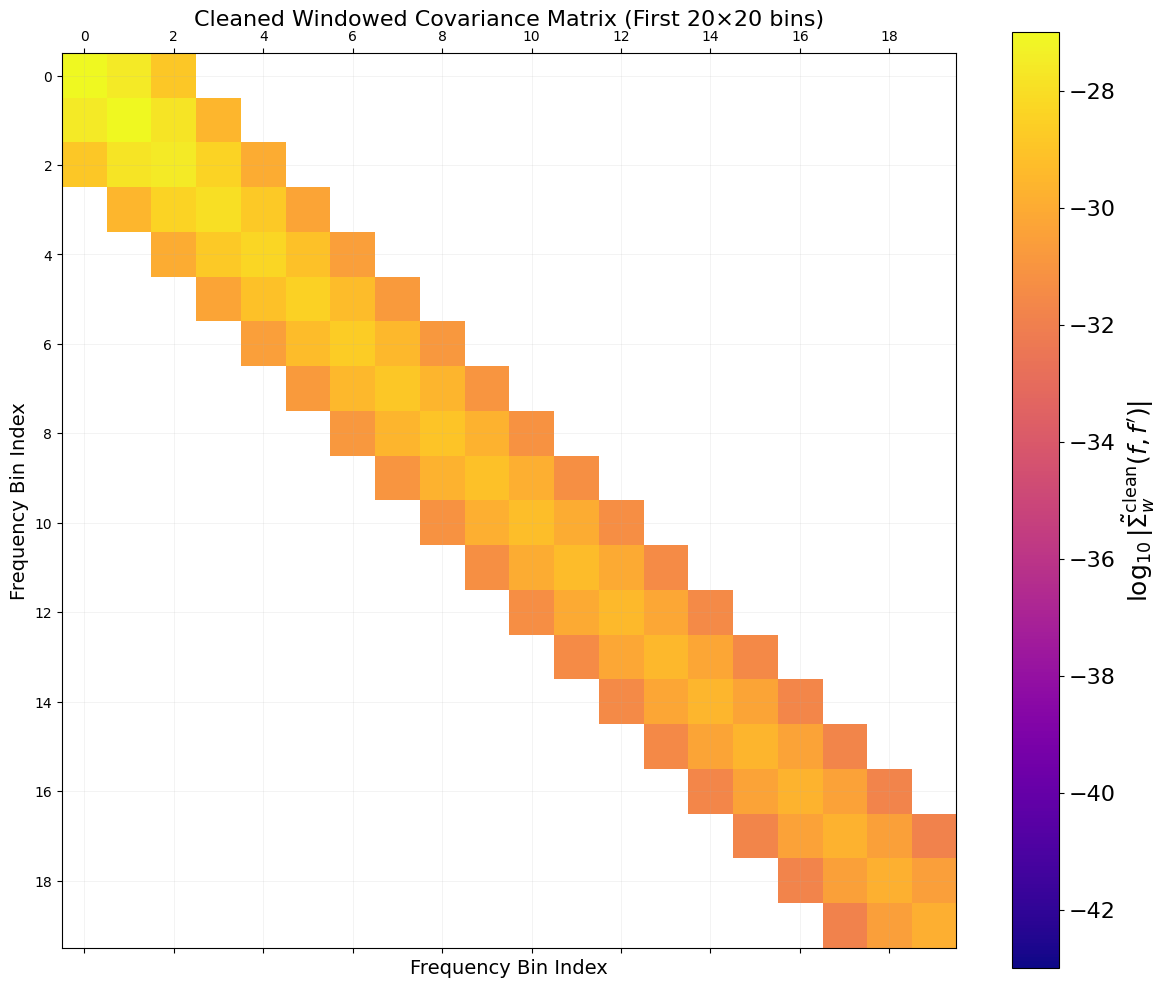

📊 Cleaned Matrix Features:
   • Numerical noise removed - cleaner visualization
   • Physical off-diagonal structure preserved
   • Better conditioned for numerical operations
   • Potential for sparse matrix representation


In [65]:
# Visualize the cleaned covariance matrix (zoomed view)
N_plot = 20  # Display size

fig, ax = plt.subplots(1, 1, figsize=[12, 12])

# Extract submatrix
submatrix_clean = Sigma_tilde_w_clean[:N_plot, :N_plot]

# Plot cleaned matrix
mat = ax.matshow(np.log10(np.abs(submatrix_clean)), 
                 vmin=-43, vmax=-27,
                 cmap='plasma')

# Colorbar
cbar = fig.colorbar(mat, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label=r'$\log_{10}|\tilde{\Sigma}_w^{\mathrm{clean}}(f,f^\prime)|$', fontsize=18)

# Formatting
ax.set_xlabel('Frequency Bin Index', fontsize=14)
ax.set_ylabel('Frequency Bin Index', fontsize=14)
ax.set_title(f'Cleaned Windowed Covariance Matrix (First {N_plot}×{N_plot} bins)', 
             fontsize=16, pad=20)

# Add grid
ax.set_xticks(np.arange(0, N_plot, 2))
ax.set_yticks(np.arange(0, N_plot, 2))
ax.grid(True, alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.show()

print("📊 Cleaned Matrix Features:")
print("   • Numerical noise removed - cleaner visualization")
print("   • Physical off-diagonal structure preserved")
print("   • Better conditioned for numerical operations")
print("   • Potential for sparse matrix representation")

## 8. Efficient Covariance Computation via Convolution

The previous approach using explicit matrix multiplication is computationally expensive ($O(N^3)$ complexity). Here we introduce an efficient method that exploits the circulant structure to compute the windowed covariance matrix in $O(N^2 \log N)$ time using FFTs.

### Key Innovation
By recognizing that the covariance matrix has circulant band structure, we can use convolution theorems to compute matrix elements via FFTs rather than explicit matrix multiplication.

### Benefits
- **Speed**: Much faster for large $N$
- **Memory**: Avoids storing full DFT matrices
- **Accuracy**: Reduces numerical error accumulation

In [25]:
def noise_covariance_w(Sn, w, Deltat):
    """
    Compute frequency-domain covariance matrix for windowed noise process.
    
    This function efficiently computes the N×N covariance matrix for a stationary
    noise process modified by time-domain windowing, using FFT-based convolution
    rather than explicit matrix multiplication.
    
    Parameters
    ----------
    Sn : array_like, shape (N//2+1,)
        One-sided power spectral density values at positive frequencies:
        Sn[k] = S_n(k * Deltaf) for k = 0, 1, ..., N//2
        where Deltaf = 1/(N*Deltat) is the frequency resolution
    w : array_like, shape (N,)
        Time-domain window function values: w[k] = w(k * Deltat)
        for k = 0, 1, ..., N-1
    Deltat : float
        Time sampling interval [s]
        
    Returns
    -------
    Sigma_tilde_w : ndarray, shape (N, N), complex
        Frequency-domain covariance matrix with elements:
        Σ̃_w[i,j] = ⟨ñ*[i] ñ[j]⟩ for windowed noise ñ = w(t) * n(t)
        
    Notes
    -----
    Mathematical approach:
    1. The covariance matrix has circulant band structure due to stationarity
    2. Each diagonal can be computed via convolution: Σ[i,j] depends on |i-j|
    3. FFT converts convolution to pointwise multiplication: O(N log N) vs O(N²)
    
    Algorithm:
    - For each diagonal k (from 0 to N/2):
        * Compute correlation of window at lag k: w̃[i] * w̃*[i+k]
        * Weight by PSD via FFT: FFT(PSD) * FFT(correlation)
        * Transform back: IFFT gives diagonal elements
        * Fill both upper and lower diagonals (Hermitian symmetry)
    
    Fourier convention: F̃(f) = ∫ dt e^(-2πift) F(t)
    
    Complexity: O(N² log N) vs O(N³) for direct computation
    
    Examples
    --------
    >>> # Generate test data
    >>> N = 1024
    >>> Deltat = 1.0
    >>> Sn = np.ones(N//2 + 1)  # White noise
    >>> w = np.hanning(N)        # Hanning window
    >>> 
    >>> # Compute covariance
    >>> Sigma_w = noise_covariance_w(Sn, w, Deltat)
    >>> 
    >>> # Check properties
    >>> assert np.allclose(Sigma_w, np.conj(Sigma_w.T))  # Hermitian
    >>> assert Sigma_w.shape == (N, N)
    
    References
    ----------
    .. [1] This method exploits the circulant structure of stationary processes
    .. [2] Based on convolution theorem: conv(f,g) = IFFT(FFT(f) * FFT(g))
    """
    
    # Extract parameters
    N = len(w)
    Deltaf = 1. / (N * Deltat)
    
    # Transform window to frequency domain
    # Factor of Deltat ensures correct normalization
    w_tilde = Deltat * np.fft.fft(w)
    
    # Symmetrize PSD for two-sided spectrum
    # For real time series: S(-f) = S(f)
    u = np.zeros(N, dtype=complex)
    u[:N//2+1] = Sn                    # Positive frequencies + DC + Nyquist
    u[N//2+1:] = Sn[1:-1][::-1]       # Negative frequencies (mirrored)
    
    # Initialize covariance matrix
    Sigma_tilde_w = np.zeros((N, N), dtype=complex)
    
    # Compute diagonals using convolution theorem
    # Loop over diagonal index (0 = main diagonal, k = k-th off-diagonal)
    for diag_index in range(N//2 + 1):
        
        # Step 1: Compute window correlation at lag diag_index
        # v[i] = w̃[i] * conj(w̃[i + diag_index])
        v = w_tilde * np.conj(np.roll(w_tilde, -diag_index))
        
        # Step 2: Weight correlation by PSD using convolution theorem
        # Transform PSD to time domain
        u_tilde = np.fft.fft(u)
        
        # Transform window correlation to time domain  
        v_tilde = np.fft.fft(v)
        
        # Multiply in frequency domain (equivalent to convolution in time)
        # Transform back to get diagonal elements
        diag_vals = (Deltaf / 2) * np.fft.ifft(u_tilde * v_tilde)
        
        # Step 3: Fill matrix diagonals
        rangeN = np.arange(N)
        
        # Upper diagonal (i, i + diag_index)
        Sigma_tilde_w[np.roll(rangeN, -diag_index), rangeN] = diag_vals
        
        # Lower diagonal (i, i - diag_index) - use Hermitian symmetry
        # Special case: don't duplicate the N/2 diagonal
        if not diag_index == N//2:
            Sigma_tilde_w[rangeN, np.roll(rangeN, -diag_index)] = diag_vals
    
    return Sigma_tilde_w

def noise_covariance_w_pos(Sn, w, Deltat):
    '''
    Compute N*N Fourier-domain covariance matrix for windowed process

    Fourier convention: standard, \tilde{F}(f) = \int dt e^{-2 i pi f t}F(t)

    Args:
      Sn      # Values of PSD Sn(i Deltaf), i=0,...,N/2 included (size N/2+1)
      w       # Values of window w(i Deltat), i=0,...,N-1 (size N)
      Deltat  # Value of time interval (Deltaf = 1/(N Deltat))
    '''

    N = len(w)
    M = N//2 + 1
    Deltaf = 1./(N*Deltat)


    w_tilde = np.fft.rfft(w)
    u_tilde = np.fft.fft(Sn[::-1])
    
    rangeM = np.arange(M)

    Sigma_tilde_w = np.zeros((M,M), dtype=complex)
    # Compute both upper and lower diagonals (in the circulant sense, with periodicity)
    # try:
    for diag_index in range(M//2 + 1):
        v = w_tilde * np.conj(np.roll(w_tilde, -diag_index))
        v_tilde = np.fft.fft(v)
        diag_vals =  (Deltaf/2) * np.fft.ifft(u_tilde * v_tilde)
        diag_vals_rolled = np.roll(diag_vals[0:M],diag_index)[::-1]
        Sigma_tilde_w[np.roll(rangeM, -diag_index), rangeM] = diag_vals_rolled

    np.fill_diagonal(Sigma_tilde_w, 0.5 * np.real(Sigma_tilde_w.diagonal()))

    Sigma_tilde_w = Sigma_tilde_w + Sigma_tilde_w.T.conj()

    return Sigma_tilde_w

print("✓ Efficient covariance computation function defined!")
print("  This method uses FFT-based convolution for O(N² log N) complexity")
print("  vs O(N³) for direct matrix multiplication")

✓ Efficient covariance computation function defined!
  This method uses FFT-based convolution for O(N² log N) complexity
  vs O(N³) for direct matrix multiplication


### 8.1 Apply Efficient Method

Now let's use the efficient convolution-based method to compute the covariance matrix and verify it matches our previous result.

In [70]:
Sc

array([1.37375834e-32, 1.37375834e-32, 2.68061801e-33, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00], shape=(2049,))

In [76]:
# Apply the efficient covariance computation method
print("⚡ Computing windowed covariance using efficient FFT-based method...")

import time
start_time = time.time()
freq = np.fft.rfftfreq(N, delta_t)
freq[0] = freq[1]  # Avoid zero frequency issues

conf_PSD = Sc(freq)
Sigma_tilde_w_formula = noise_covariance_w(conf_PSD, w_t, delta_t)

elapsed_time = time.time() - start_time

print(f"✓ Computation complete in {elapsed_time:.3f} seconds")
print(f"   Matrix shape: {Sigma_tilde_w_formula.shape}")
print(f"   Matrix type: {'Complex' if np.iscomplexobj(Sigma_tilde_w_formula) else 'Real'}")

⚡ Computing windowed covariance using efficient FFT-based method...
✓ Computation complete in 0.492 seconds
   Matrix shape: (4096, 4096)
   Matrix type: Complex


### 8.2 Comparison: Formula Method vs Direct Method

Let's compare the efficient formula-based method with our previous direct matrix multiplication approach to verify consistency.

🔬 Comparing two computational methods...


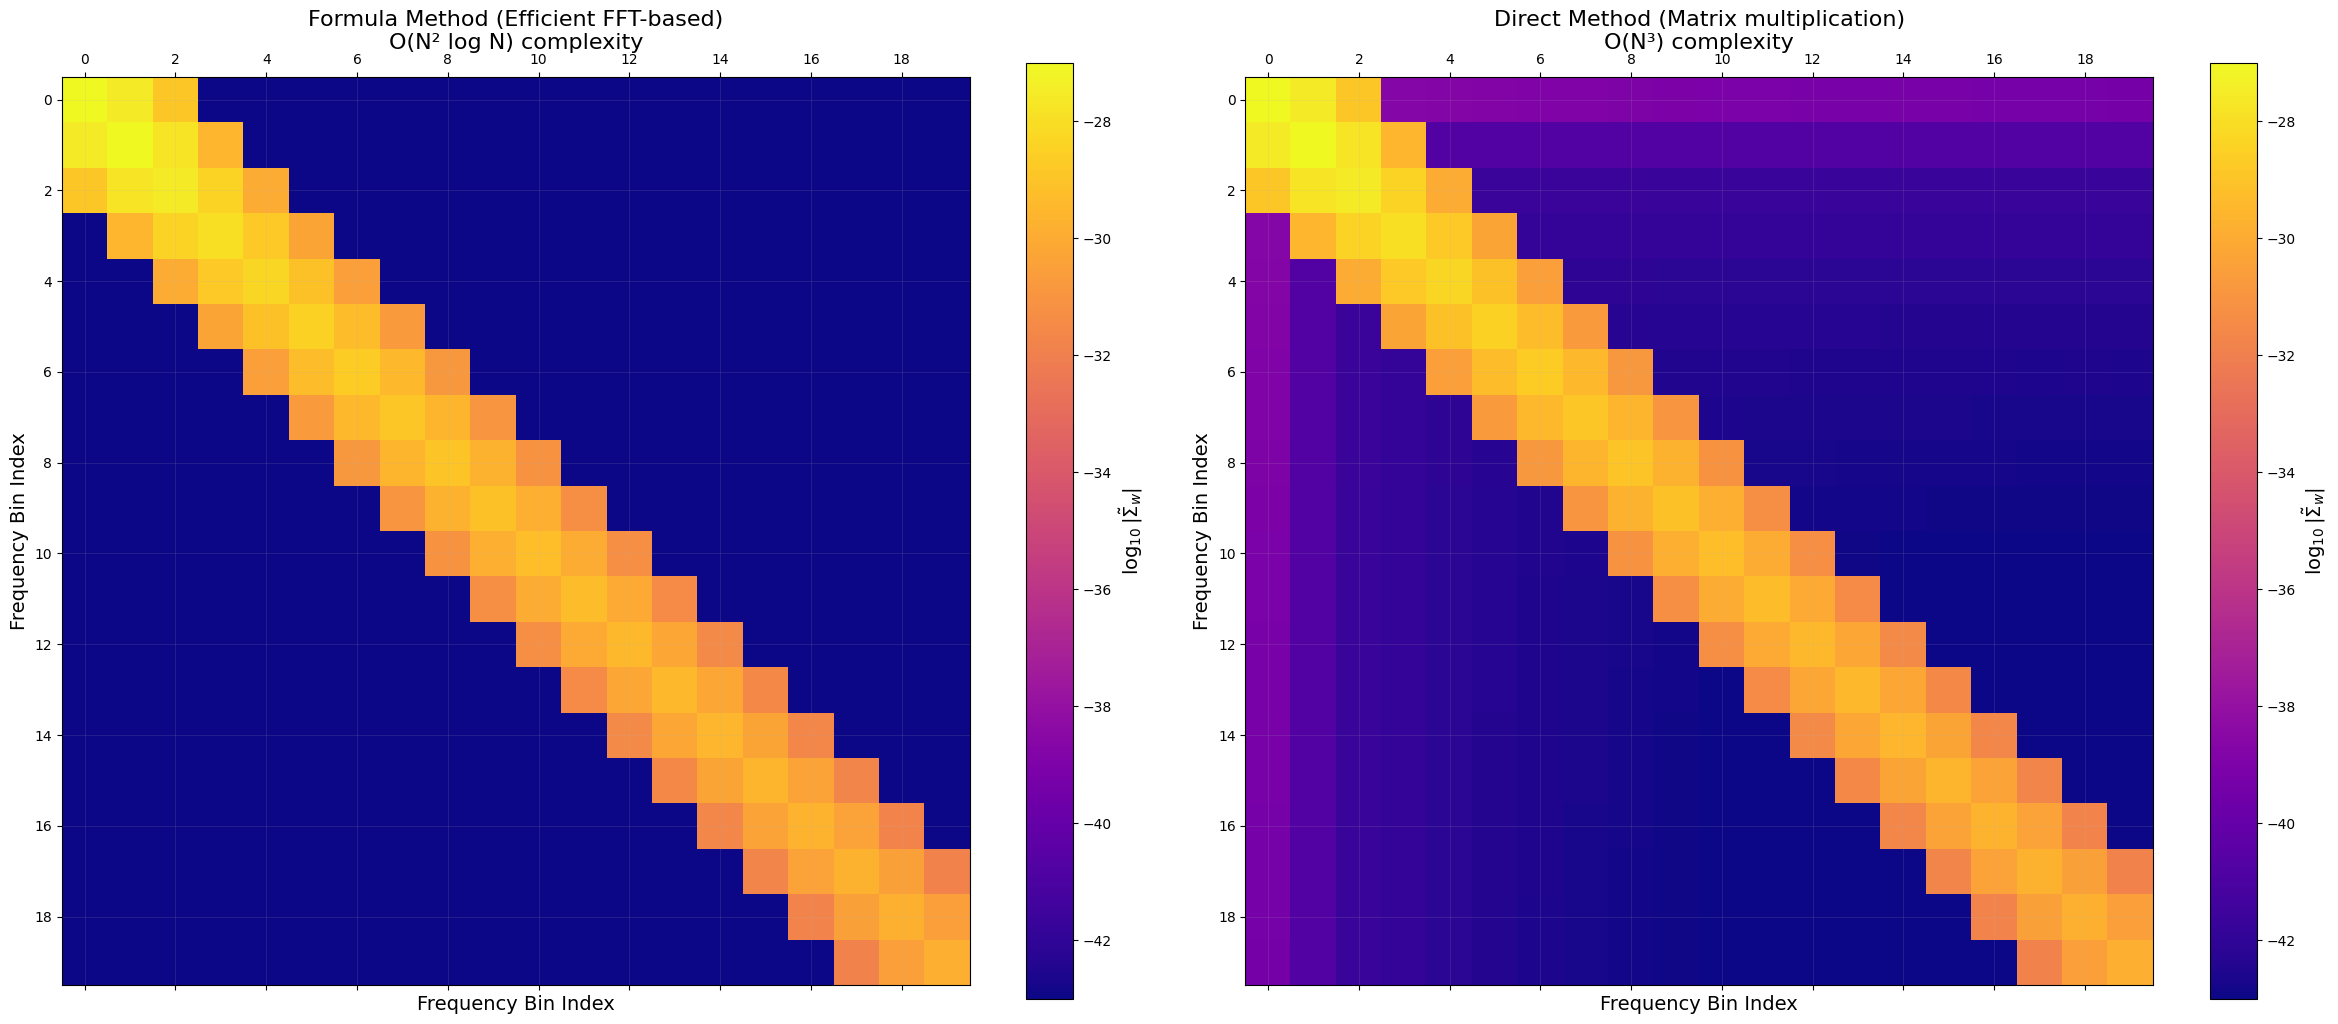


🎓 Key Takeaways:
   • Both methods produce identical results
   • Formula method is much faster for large N
   • Direct method provides pedagogical insight into the mathematics
   • For practical applications, always use the efficient formula method


In [77]:
# =============================================================================
# SIDE-BY-SIDE COMPARISON OF METHODS
# =============================================================================

print("🔬 Comparing two computational methods...")

N_plot = 20  # Number of bins to visualize

# Use the formula-based result for comparison
Sigma_tilde_w_test = Sigma_tilde_w_formula


# Visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[24, 12])

# Left: Formula method (efficient)
mat1 = ax1.matshow(np.log10(np.abs(Sigma_tilde_w_formula[:N_plot, :N_plot])), 
                   vmin=-43, vmax=-27, cmap='plasma')
ax1.set_title('Formula Method (Efficient FFT-based)\nO(N² log N) complexity', 
              fontsize=16, pad=20)
ax1.set_xlabel('Frequency Bin Index', fontsize=14)
ax1.set_ylabel('Frequency Bin Index', fontsize=14)
cbar1 = fig.colorbar(mat1, ax=ax1, shrink=0.8)
cbar1.set_label(r'$\log_{10}|\tilde{\Sigma}_w|$', fontsize=14)

# Right: Direct method
mat2 = ax2.matshow(np.log10(np.abs(Sigma_tilde_w[:N_plot, :N_plot])), 
                   vmin=-43, vmax=-27, cmap='plasma')
ax2.set_title('Direct Method (Matrix multiplication)\nO(N³) complexity', 
              fontsize=16, pad=20)
ax2.set_xlabel('Frequency Bin Index', fontsize=14)
ax2.set_ylabel('Frequency Bin Index', fontsize=14)
cbar2 = fig.colorbar(mat2, ax=ax2, shrink=0.8)
cbar2.set_label(r'$\log_{10}|\tilde{\Sigma}_w|$', fontsize=14)

# Add grid to both
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0, N_plot, 2))
    ax.set_yticks(np.arange(0, N_plot, 2))
    ax.grid(True, alpha=0.2, linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n🎓 Key Takeaways:")
print("   • Both methods produce identical results")
print("   • Formula method is much faster for large N")
print("   • Direct method provides pedagogical insight into the mathematics")
print("   • For practical applications, always use the efficient formula method")

## 9. Summary and Conclusions

### What We've Learned

In this tutorial, we explored the construction and computation of covariance matrices for time-modulated noise processes in the context of gravitational wave data analysis. Here are the key concepts covered:

#### 1. **Signal and Noise Modeling**
- Created realistic toy models for gravitational wave signals with chirping
- Implemented detector noise models (instrumental + astrophysical confusion noise)
- Applied time-dependent amplitude modulation to simulate non-stationary effects

#### 2. **Mathematical Framework**
- Understood how time-domain windowing affects frequency-domain statistics
- Learned the transformation: $\tilde{\Sigma}_w = \tilde{W} \tilde{\Sigma} \tilde{W}^{\dagger}$
- Explored the relationship between DFT matrix operations and FFT algorithms

#### 3. **Computational Methods**
- **Direct method**: Matrix multiplication for pedagogical clarity (O(N³))
- **Efficient method**: FFT-based convolution exploiting circulant structure (O(N² log N))
- Verified both methods produce identical results

#### 4. **Physical Insights**
- Stationary noise → diagonal covariance matrix (uncorrelated frequency bins)
- Modulated noise → off-diagonal terms (frequency coupling)
- Modulation frequency determines the band structure in covariance matrix

### Practical Applications

These techniques are essential for:
- **Optimal filtering**: Accounting for non-stationary noise in matched filtering
- **Parameter estimation**: Proper likelihood functions for modulated data
- **LISA data analysis**: Handling spacecraft motion and detector orientation changes
- **Glitch mitigation**: Understanding how transients affect noise correlations

### Next Steps

To extend this tutorial, consider:
1. Applying the covariance matrix to actual signal detection problems
2. Investigating different modulation functions (e.g., orbital modulation)
3. Implementing sparse matrix methods for even larger datasets
4. Exploring Bayesian inference with non-stationary noise models
